In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime
import timeit

In [2]:
# Convolution Helper functions
def movingavg(signal,wsize = 10):
    stepsize = 1
    N = len(signal)
    smoothed = np.zeros((N,))
    # Make convolution window padded to fit dimensions of signal
    cwindow = np.ones((wsize,)) / wsize
    padded_cwindow = np.pad(cwindow,(0,N-wsize),'constant')
    for idx in range(N):
        smoothed[idx]  = sum(padded_cwindow*signal)
        padded_cwindow = np.roll(padded_cwindow, 1)
    return smoothed
def fft_convolve(signal,window):
    fft_signal = np.fft.fft(signal)
    fft_window = np.fft.fft(window)
    return np.fft.ifft(fft_signal*fft_window)

def fft_autocorr(signal):
    N = len(signal)
    signal = np.pad(signal,(0,N),'constant')
    window = np.flipud(signal)
    
    corrs = fft_convolve(signal, window)
    corrs = np.roll(corrs, N//2+1)[:N]
    return corrs

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

# Helper function to generate waves
def genSquareWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate Square waveform
    nframes   = int((frate/(2*freq))+1)
    tempwav1  = np.full((1,nframes),-amp)
    tempwav2  = np.full((1,nframes),amp)
    tempwav   = np.append(tempwav1[:nframes-1],tempwav2[:nframes-1])
    # Shift to offset
    startidx = int(nframes/2)
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    #print(2*nframes,len(ts),len(ts2))
    return wavout,ts

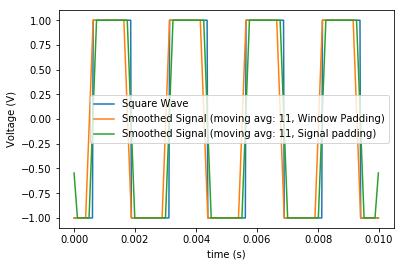

In [3]:
# Convolution + Padding
sqwave,ts = genSquareWave(amp = 1,freq = 400,dur = 1,frate = 44100)
lseg = ts <= 0.01
seg_sqwave = sqwave[lseg]
seg_ts = ts[lseg]
# Create convolution window for weighted sum
wsize = 11
mavg_sqwave1 = movingavg(seg_sqwave,wsize) # pads the convolution window and rolls
# or even better..
wsize = 11
cwindow = np.ones((wsize,)) / wsize
mavg_sqwave2 = np.convolve(seg_sqwave,cwindow,mode='same')

plt.plot(seg_ts,seg_sqwave)
plt.plot(seg_ts,mavg_sqwave1)
plt.plot(seg_ts,mavg_sqwave2)
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend(['Square Wave','Smoothed Signal (moving avg: 11, Window Padding)','Smoothed Signal (moving avg: 11, Signal padding)'])
plt.show()
  

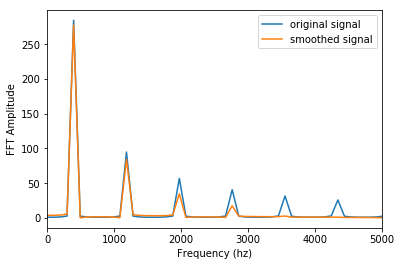

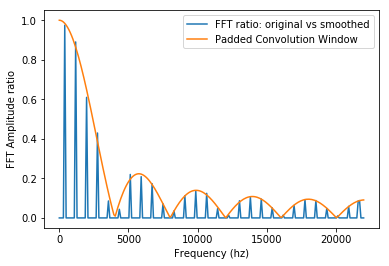

Notice that the relationship of the Convolution window and the Smoothed Wave in the Power spectrum
**Convolution Thereom**
	Convolution in the time domain corresponds to multiplication in the frequency domain.


In [5]:
spec1,fq1 = make_spectrum(seg_sqwave,44100)
spec2,fq2 = make_spectrum(mavg_sqwave2,44100)
plt.plot(fq1,np.absolute(spec1))
plt.plot(fq2,np.absolute(spec2))
plt.xlim([0,5000])
plt.ylabel('FFT Amplitude')
plt.xlabel('Frequency (hz)')
plt.legend(['original signal','smoothed signal'])
plt.show()


# Convolve (smooth) signal
N = len(seg_sqwave)
wsize = 11
cwindow = np.ones((wsize,)) / wsize # uniform dist
padded_cwindow = np.pad(cwindow,(0,N-wsize),'constant')

# comput spectrum of convolved (smoothed) signal
spec3,fq3 = make_spectrum(padded_cwindow,44100)
ratio = np.absolute(spec2)/np.absolute(spec1)
ratio[np.absolute(spec1) < 5] = 0

# Compare Convolution FFT with FFT ratios
plt.plot(fq1,ratio)
plt.plot(fq3,np.absolute(spec3))
plt.ylabel('FFT Amplitude ratio')
plt.xlabel('Frequency (hz)')
plt.legend(['FFT ratio: original vs smoothed','Padded Convolution Window'])
plt.show()
print('Notice that the relationship of the Convolution window and the Smoothed Wave in the Power spectrum')
print('**Convolution Thereom**')
print('\tConvolution in the time domain corresponds to multiplication in the frequency domain.')

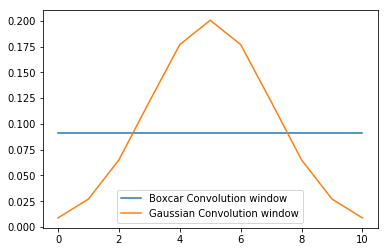

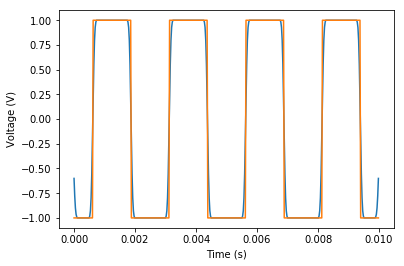

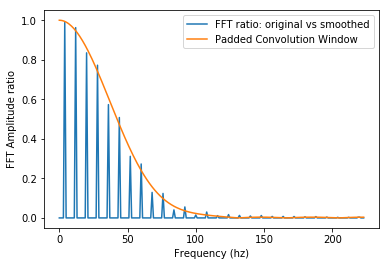

Notice that the relationship of the Convolution window and the Smoothed Gaussian Wave in the Power spectrum
	Less Bouncing (sidelobs)
Gaussian Convolution does better job at cutting off higher frequencies 
 --> ratio drops off in proportion to exp(-f^2), which is much faster than 1/f .


In [6]:
# Comparing Convolution Filters (Gaussian vs simple moving avg)
wsize  = 11
sig    = 2
cgauss = signal.gaussian(M = wsize,std = sig)
cgauss /= sum(cgauss) #normalize
mavg_BCsqwave = np.convolve(seg_sqwave,cwindow,mode='same')
mavg_Gsqwave = np.convolve(seg_sqwave,cgauss,mode='same')
# Visualize the difference of a moving avg vs guassian convolution window
plt.plot(cwindow)
plt.plot(cgauss)
plt.legend(['Boxcar Convolution window','Gaussian Convolution window'])
plt.show()
plt.plot(seg_ts,mavg_Gsqwave)
plt.plot(seg_ts,seg_sqwave)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
# Create spectrums based with various convolution windows
N = len(seg_sqwave)
padded_cgauss     = np.pad(cgauss,(0,N-wsize),'constant')
seg_specSignal,fq = make_spectrum(seg_sqwave,44100)
G_specSignal,fq1  = make_spectrum(mavg_Gsqwave,44100)
G_specWindow,fq2  = make_spectrum(padded_cgauss,44100)
ratio = np.absolute(G_specSignal)/np.absolute(seg_specSignal)
ratio[np.absolute(seg_specSignal) < 5] = 0
# Compare FFT ratios
plt.plot(ratio)
plt.plot(np.absolute(G_specWindow))
plt.ylabel('FFT Amplitude ratio')
plt.xlabel('Frequency (hz)')
plt.legend(['FFT ratio: original vs smoothed','Padded Convolution Window'])
plt.show()
print('Notice that the relationship of the Convolution window and the Smoothed Gaussian Wave in the Power spectrum')
print('\tLess Bouncing (sidelobs)')
print('Gaussian Convolution does better job at cutting off higher frequencies ')
print(' --> ratio drops off in proportion to exp(-f^2), which is much faster than 1/f .')

In [9]:
# Real World Application: FB prices
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/CSVFiles/'
fname = datafolder + 'fb.csv'
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv(fname, header=0, names=names, parse_dates=[0])
df.head()
prices = df.close.values[::-1]
dates  = pd.to_datetime(df.date.values[::-1])

36 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
136 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


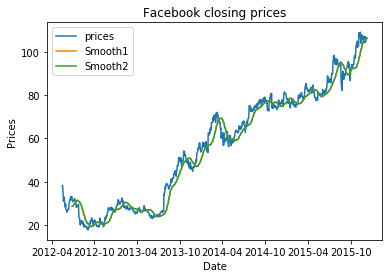

Both smoothing methods yield the same result


In [10]:
# Compare Convolution methods to smooth data [Efficiency]
N       = len(prices)
wsize   = 30
sig     = 6
cgauss  = signal.gaussian(M = wsize,std = sig)
cgauss  /= sum(cgauss) #normalize
# Method 1: convolution
%timeit -r1 -o np.convolve(prices,cgauss,mode = 'valid')
gsmooth       = np.convolve(prices,cgauss,mode = 'valid')
# Method 2: ifft(fft)
padded_cgauss = np.pad(cgauss,(0,N-wsize),'constant')
%timeit -r1 -o fft_convolve(prices,padded_cgauss)
gsmooth2  = fft_convolve(prices,padded_cgauss)
gsmooth2  = gsmooth2[wsize-1:]

plt.plot(dates,prices)
plt.plot(dates[wsize-1:],np.absolute(gsmooth))
plt.plot(dates[wsize-1:],np.absolute(gsmooth2))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(['prices','Smooth1','Smooth2'])
plt.title('Facebook closing prices')
plt.show()
print('Both smoothing methods yield the same result')

443 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
141 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


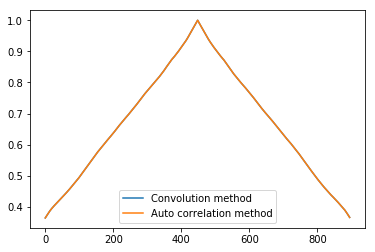

Both Autocorrelation methods yield the same result


In [11]:
# Compare Convolution methods for autocorrelation [Efficiency]
%timeit -r1 fft_autocorr(prices)
corr1  = fft_autocorr(prices.copy())
%timeit -r1 np.correlate(prices,prices,mode = 'same') 
corr2 = np.correlate(prices,prices,mode = 'same') 
plt.plot(np.absolute(corr1)/np.max(np.absolute(corr1)))
plt.plot(corr2/np.max(corr2))
plt.legend(['Convolution method','Auto correlation method'])
plt.show()
print('Both Autocorrelation methods yield the same result')